In [2]:
import os
import sys
sys.path.append(os.path.join('..', '..'))

from scripts.core.text import remove_punctuation

from scripts.data_loaders.common import show_sample, TARGET_SAMPLE_RATE
# from scripts.data_loaders.TIMIT import TIMITDataset
# from scripts.data_loaders.L2ARCTIC import L2ArcticDataset
# from scripts.data_loaders.EpaDB import EpaDBDataset
# from scripts.data_loaders.SpeechOcean import SpeechOceanDataset
# from scripts.data_loaders.ISLE import ISLEDataset
# from scripts.data_loaders.TalkBank import TalkBankDataset
# from scripts.data_loaders.SpeechAccent import SpeechAccentDataset
# from scripts.data_loaders.CORAAL import CORAALDataset

# # NOTE: run one model at a time if you are short on memory
# from scripts.asr.whisper import whisper_transcribe_from_array, whisper_output_to_text
# # from scripts.asr.whisper import whisper_output_to_text
# # from repos.whisper.transcribe import transcribe as whisper_transcribe_from_array
# # from scripts.asr.azure_speech import azure_transcribe_from_array
# # from scripts.asr.google_speech import google_transcribe_from_array
# # from scripts.asr.salad import salad_transcribe_from_array
# from scripts.asr.owsm import owsm_transcribe_from_array
# from scripts.asr.mms import mms_transcribe_from_array
# from scripts.asr.qwen import qwen_transcribe_from_array
# from scripts.asr.canary import canary_transcribe_from_array
# # from scripts.asr.canary_api import canary_transcribe_from_array

from scripts.eval.metrics import cer, wer
from scripts.ipa_transcription.wav2vec2 import clear_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

###################### Plotting Style ######################
from cycler import cycler

plt.style.use('seaborn-v0_8-colorblind')

# Get current property cycle (the seaborn colorblind palette)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Add an extra color
extra_color = "#6C7394"  
colors.append(extra_color)

# Set the new color cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)
############################################################

from IPython.display import clear_output
clear_output()

In [3]:
RESULT_CSV = os.path.join("..", "..", ".data", "scores_asr.csv")

## Load Data

In [3]:
TestSet = namedtuple('TestSet', ['name', 'data', 'accent_fn'])

testsets = [
    TestSet('TIMIT', TIMITDataset(split='test', include_speaker_info=True, include_text=True), lambda _: 'USA'),
    TestSet('EpaDB', EpaDBDataset(split='test', include_speaker_info=True, include_text=True), lambda _: 'Argentina'),
    TestSet('SpeechOcean', SpeechOceanDataset(split='test', include_speaker_info=True, include_text=True), lambda _: 'Mandarin'),
    TestSet('ISLE', ISLEDataset(split="all", include_speaker_info=True, include_text=True), lambda m: m['native_language']),
    TestSet('CORAAL', CORAALDataset(split='ATL', include_speaker_info=True, include_text=True, max_samples_per_recording=15), lambda _: 'AAVE'),
    TestSet('L2-Arctic', L2ArcticDataset(split='suitcase_corpus', include_speaker_info=True, include_text=True, max_phonemes=50), lambda m: m['native-language']),
    TestSet('BELC', TalkBankDataset(split="BELC", include_speaker_info=True, include_text=True), lambda _: 'Spanish'),
    TestSet('SAA', SpeechAccentDataset(include_speaker_info=True, include_text=True, max_phonemes=50), lambda m: m['native_language'].capitalize())
]

In [4]:
for name, dataset, accent_fn in testsets:
    print(name)
    show_sample(dataset[0], skip_plot=True, format_metadata=lambda m: (accent_fn(m[0]), ' - ', m[1]))

TIMIT
IPA: ʃiɦædjɝdɑɹksuɾɪŋɡɹisiwɑʃwɑɾɝʔɔljiɚ
Metadata: USA  -  She had your dark suit in greasy wash water all year


EpaDB
IPA: aʊɝnaɪsɹɛdθʰosʰ
Metadata: Argentina  -   our nice red  toy 


SpeechOcean
IPA: mɑɹkɪzɡoʊɪŋtusiɛˈlɪfʌnt
Metadata: Mandarin  -  MARK IS GOING TO SEE ELEPHANT


ISLE
IPA: aɪˈsɛˈdwaɪˈtnɒˈtbeɪˈts
Metadata: Italian  -  I SAID WHITE NOT BAIT


CORAAL
IPA: None
Metadata: AAVE  -  I'm a female.


L2-Arctic
IPA: jɛˈsʌˈmɪˈtsiˈmzɪffɹʌˈmðʌfɝˈsbɪˈktʃɝzzɪsɪzlaɪˈkʌbɪˈktʃɝoʊfʌˈ
Metadata: Arabic  -  yes um it seems that from the first pictures this is like a picture of


BELC
IPA: 
Metadata: Spanish  -  okay hm the story starts with a woman a poor woman dressing in rucks and looking at a a


SAA
IPA: pliːzəkʌlstɛlʌæʃkhɜ˞tɔːbʁiːŋðiːsɪθiːŋzwɪθhɜ˞fʁʌmðztɔːʁsɪks
Metadata: Portuguese  -  please call stella Ask her to bring these things with her from the store six spoons of fresh snowpeas


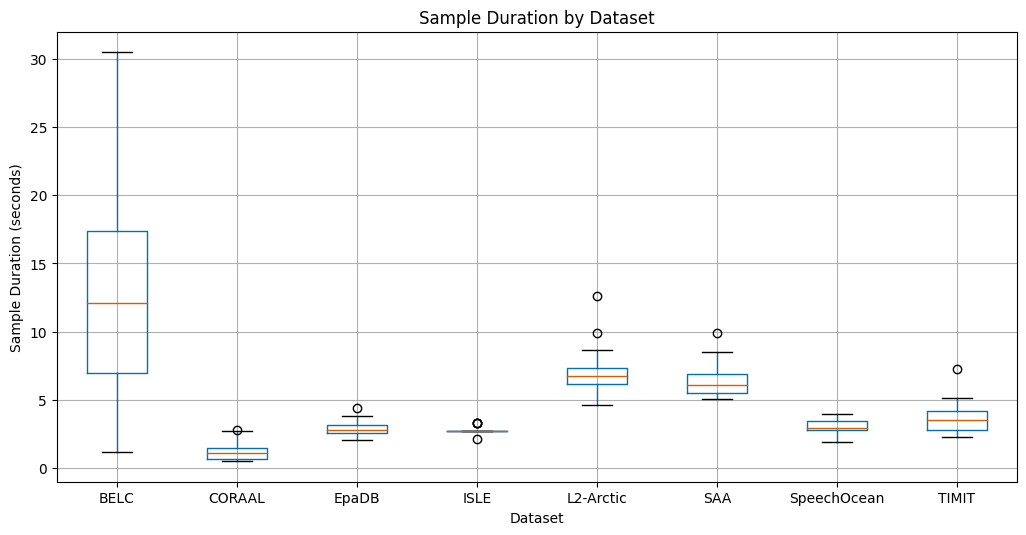

In [5]:
all_lengths = pd.DataFrame(columns=["dataset", "length"])
for name, dataset, _ in testsets:
    lengths = []
    for s in dataset[:22]: # type: ignore
        lengths.append(len(s[1]) / TARGET_SAMPLE_RATE) # type: ignore
    all_lengths = pd.concat([all_lengths, pd.DataFrame({
        'dataset': [name] * len(lengths),
        'length': lengths
    })])
ax = all_lengths.boxplot('length', by='dataset', figsize=(12, 6))
ax.set_xlabel("Dataset")
ax.set_ylabel("Sample Duration (seconds)")
ax.set_title("Sample Duration by Dataset")
plt.suptitle("")
plt.show()

## Run Models

In [4]:
columns = ['dataset', 'model', 'release_date', 'sample_id', 'native_language', 'groundtruth',  'prediction', 'wer', 'cer']

if os.path.exists(RESULT_CSV):
    results = pd.read_csv(RESULT_CSV)
else:
    results = pd.DataFrame(columns=columns)

In [ ]:
Model = namedtuple('Model', ['name', 'release_date', 'transcribe_fn'])

models = [
    Model('Whisper Large v1', '2022-09', lambda arr: whisper_output_to_text(whisper_transcribe_from_array(arr, model='large-v1', language='en'))),
    Model('Whisper Large v2', '2022-12', lambda arr: whisper_output_to_text(whisper_transcribe_from_array(arr, model='large-v2', language='en'))),
    Model('MMS 1B All',       '2023-05', mms_transcribe_from_array),
    Model('Whisper Large v3', '2023-11', lambda arr: whisper_output_to_text(whisper_transcribe_from_array(arr, model='large-v3', language='en'))),
    Model('OWSM 3.1 1B',      '2024-01', owsm_transcribe_from_array),
    Model('Qwen2 Audio 7B',   '2024-08', qwen_transcribe_from_array),
    Model('Canary Qwen 2.5B', '2025-07', canary_transcribe_from_array),
]

In [ ]:
for model_name, model_date, transcribe_fn in models:
    print(model_name + "...")
    for dataset_name, dataset, accent_fn in testsets:
        print("  - " + dataset_name + "...")
        for sample_id, sample in enumerate(dataset):
            clear_cache()
            if any((results['dataset'] == dataset_name) & (results['model'] == model_name) & (results['sample_id'] == sample_id)):
                continue # already computed
            audio = sample[1]
            transcription: str = transcribe_fn(audio)
            metadata = sample[2]
            native_language = accent_fn(metadata)
            groundtruth: str = sample[3]
            new_row = pd.DataFrame(dict(
                dataset=[dataset_name],
                model=[model_name],
                release_date=[model_date],
                sample_id=[sample_id],
                native_language=[native_language],
                groundtruth=[groundtruth],
                prediction=[transcription],
                wer=[wer(remove_punctuation(transcription.lower()), remove_punctuation(groundtruth.lower()))],
                cer=[cer(remove_punctuation(transcription.lower().strip().replace("  ", " ")), remove_punctuation(groundtruth.lower().strip().replace("  ", " ")))],
            ), columns=columns)
            results = pd.concat([results, new_row])
            # results.to_csv(RESULT_CSV, index=False)
            new_row.to_csv(RESULT_CSV, mode="a", index=False, header=False)

## Plot Results

In [9]:
dataset_groups = [
    ['L1-Arctic', 'L2-Arctic'],
    ['Openslr83', 'CORAAL'],
    ['SAA', ''],
    ['TIMIT', 'EpaDB', 'SpeechOcean', 'ISLE', 'BELC', 'Openslr70']
]

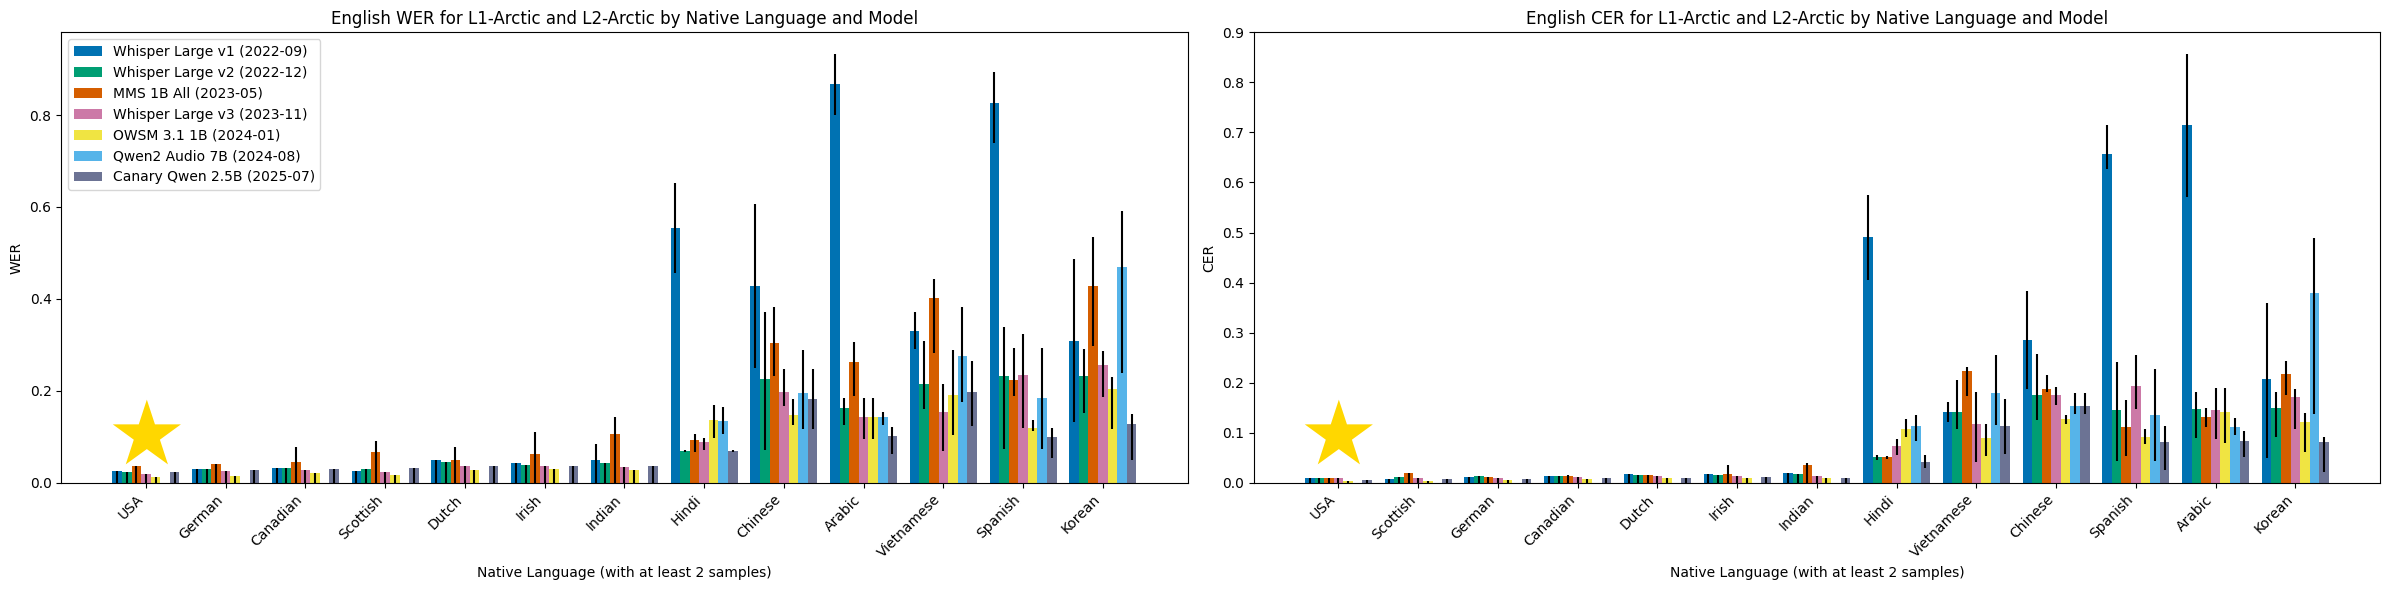

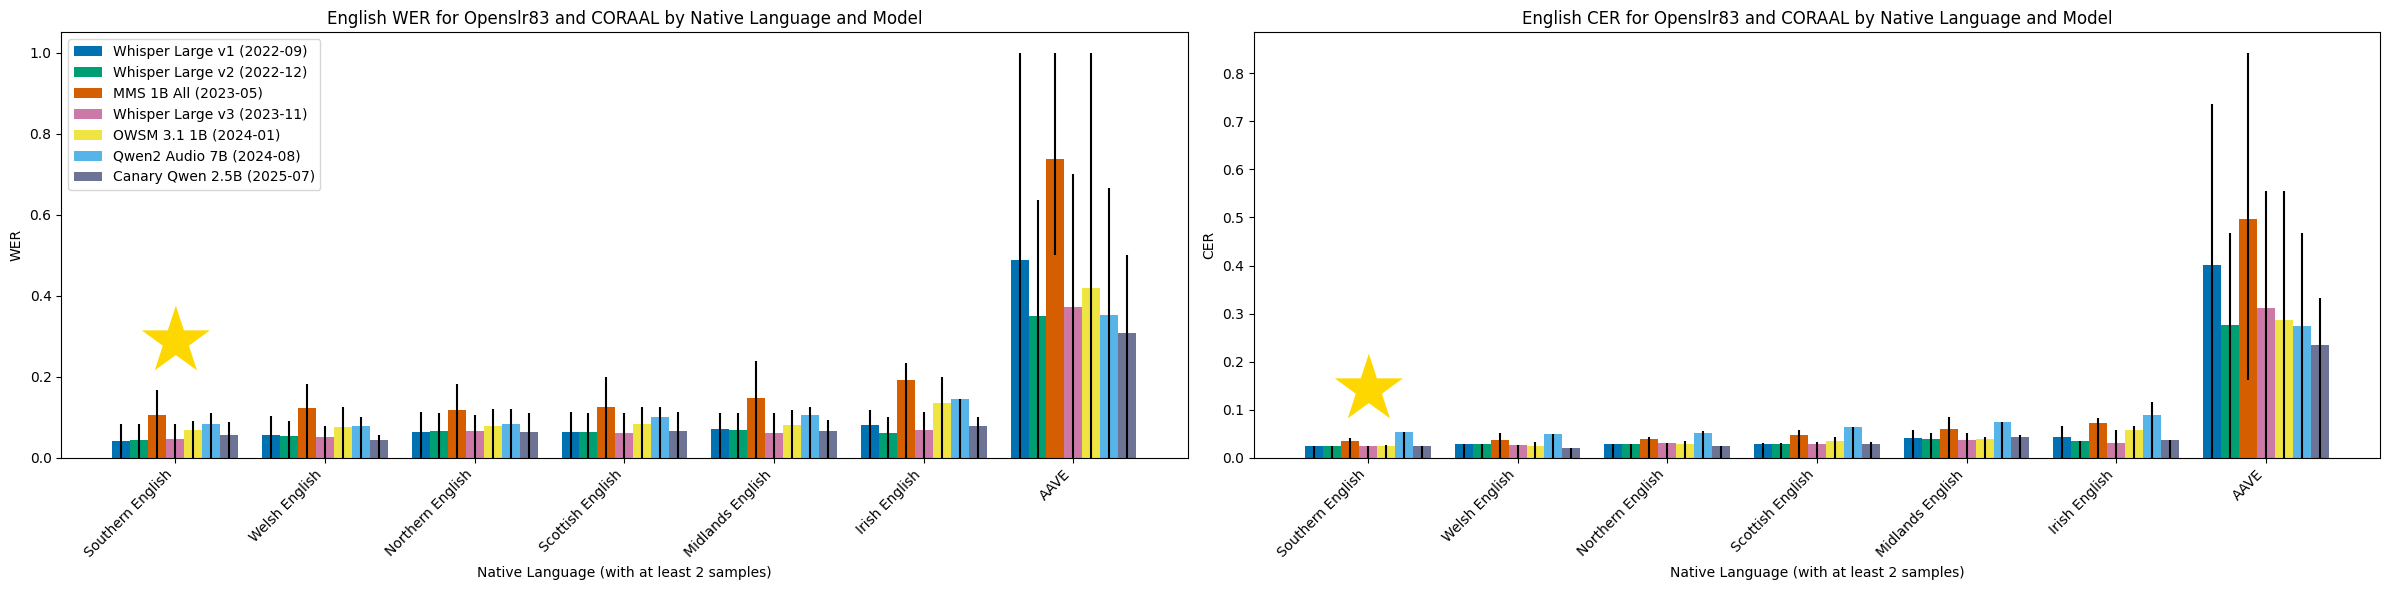

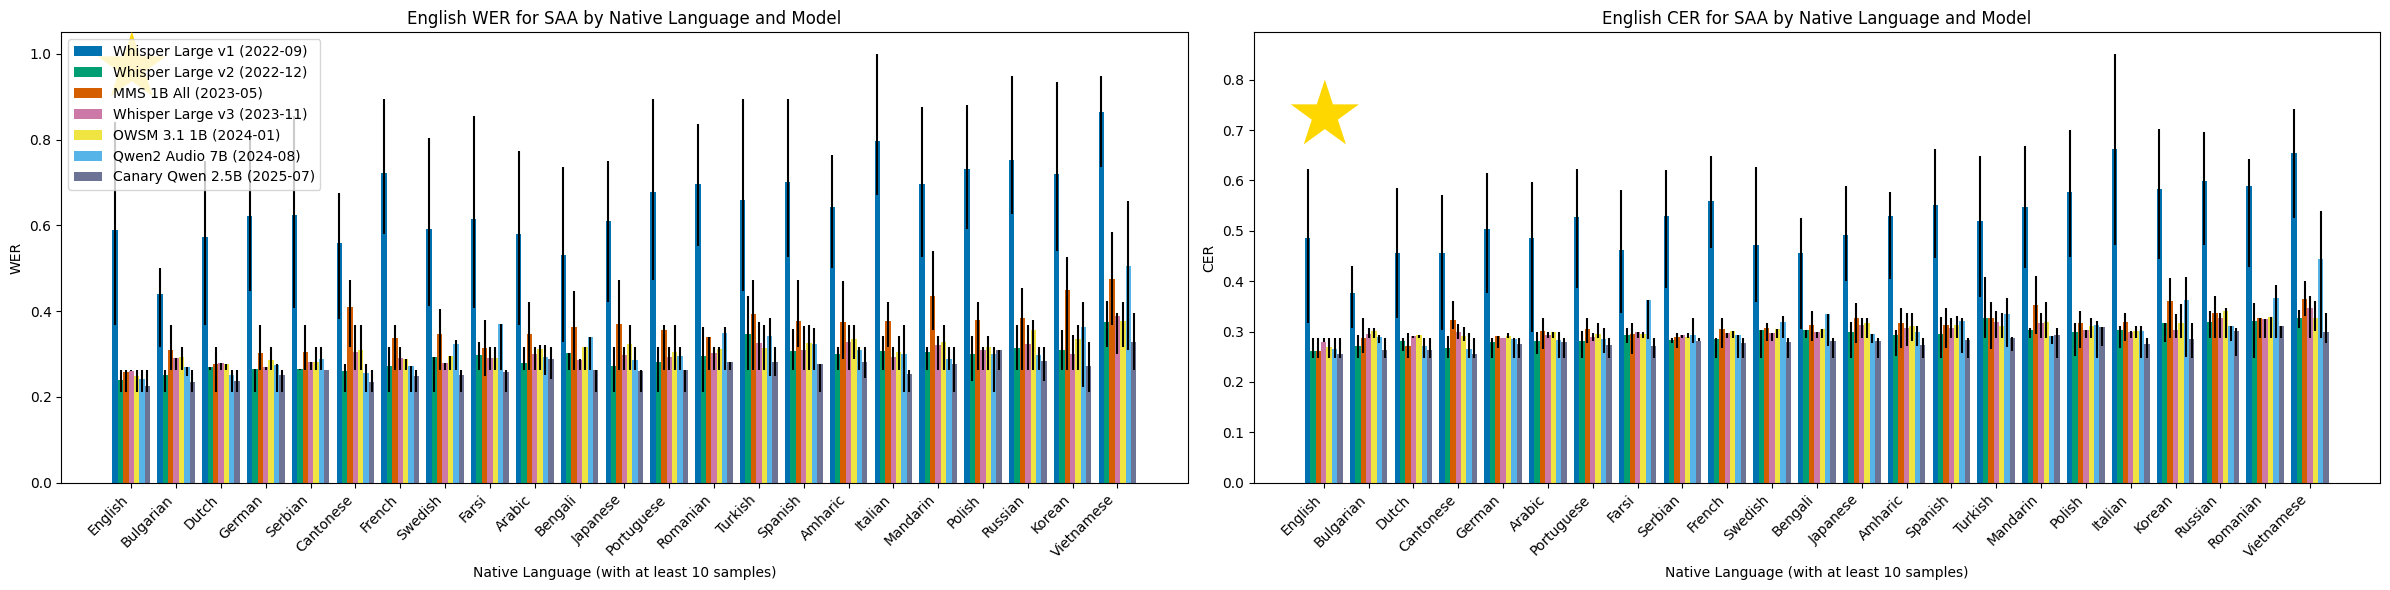

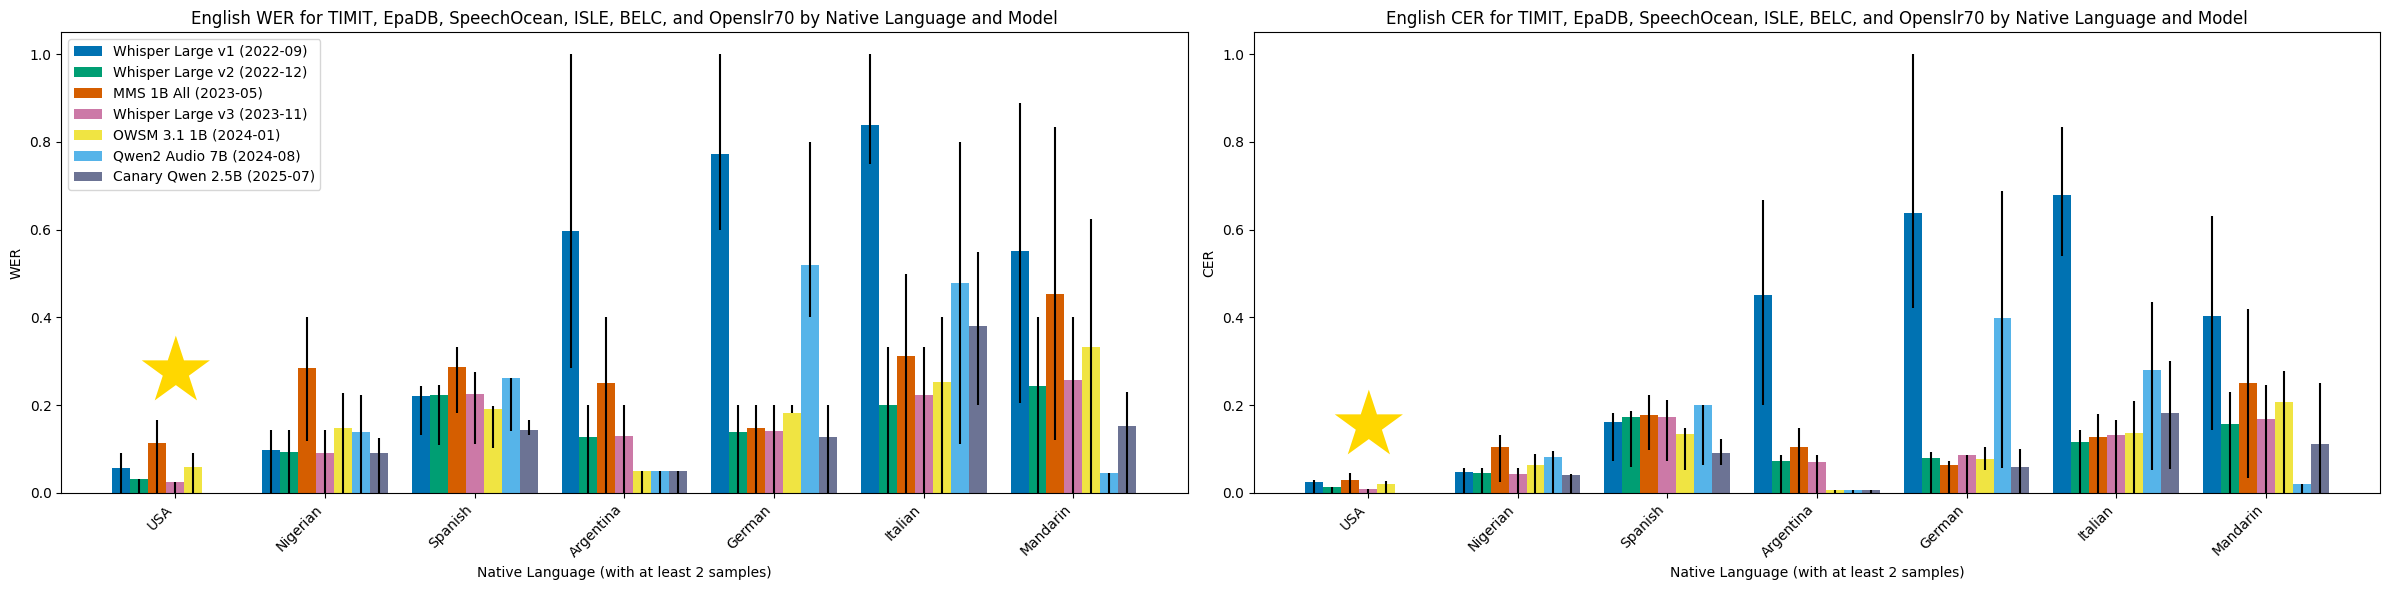

In [10]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def comma_and(it):
    l = list(it)
    oxford = len(l) > 2
    t = l.pop(0)
    if len(l) > 0:
        while len(l) > 1:
            t += ", " + l.pop(0)
        if oxford:
            t += ','
        t += " and " + l.pop(0)
    return t

for group in dataset_groups:
    df = results[results['dataset'].isin(group)].copy()

    df = df[(df["cer"] <= 1) & (df["wer"] <= 1)] # drop outliers
    MIN_SAMPLES = 10 if 'SAA' in group else 2 # ensure we have at least MIN_SAMPLES samples for a language to include it
    t = pd.DataFrame(df['native_language'].value_counts() / len(df['model'].unique()) > MIN_SAMPLES).reset_index()
    t = t[t['count']]['native_language'].unique()
    df = df[df['native_language'].isin(t)]
    
    df["release_date"] = df["release_date"].apply(lambda s: s.strip())
    df['model'] = df.apply(lambda r: f'{r["model"]} ({r["release_date"]})', axis=1)
    grouped = df.groupby(['native_language', 'model']).aggregate({'release_date': lambda c: list(c)[0], 'wer': ['mean', q25, q75], 'cer': ['mean', q25, q75]}).reset_index()
    grouped.columns = ['native_language', 'model', 'release_date', 'wer_mean', 'wer_q25', 'wer_q75', 'cer_mean', 'cer_q25', 'cer_q75']
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 6))
    for metric, ax in zip(['wer', 'cer'], axs):
        languages = df.groupby('native_language').aggregate({metric: 'mean'}).sort_values(metric).reset_index()['native_language'].unique()
        bar_width = 0.12  # width of each bar
        x = np.arange(len(languages))  # x positions for languages

        # Loop over models in order of first release_date seen
        for i, model in enumerate(grouped.sort_values('release_date')['model'].unique()):
            model_data = grouped[grouped['model'] == model]
            # Align bars by language index
            positions = [np.where(languages == lang)[0][0] for lang in model_data['native_language']]
            ax.bar(
                x=np.array(positions) + i*bar_width, 
                height=model_data[metric + "_mean"], 
                yerr=np.array([model_data[metric + "_mean"].to_numpy() - model_data[metric + "_q25"].to_numpy(), model_data[metric + "_q75"].to_numpy() - model_data[metric + "_mean"].to_numpy()]).clip(0),
                width=bar_width, 
                label=model
            )

        ax.set_xticks(x + bar_width * (len(grouped['model'].unique())-1) / 2)
        ax.set_xticklabels(languages, rotation=45, ha='right')
        ax.set_xlabel(f'Native Language (with at least {MIN_SAMPLES} samples)')
        ax.set_ylabel(metric.upper())
        ax.set_title('English ' + metric.upper() + ' for ' + comma_and(filter(lambda x: x, group)) + ' by Native Language and Model')
        if list(axs).index(ax) == 0:
            ax.legend(loc='upper left')

        # annotate mainstream dialect with a star
        mainstream = ["English", 'USA', "Southern English"]
        for m in mainstream:
            if m not in languages:
                continue

            x_coord = x[list(languages).index(m)] + bar_width * (len(grouped['model'].unique())-1)/2   # center of first group
            height = grouped[grouped['native_language'] == m][metric + "_q75"].max()

            ax.text(
                x_coord, 
                min(height + 0.02, height * 1.02),   # a little above the tallest error bar
                "★", 
                ha='center', 
                va='bottom', 
                fontsize=64, 
                color='gold'
            )

    plt.tight_layout()
    plt.show()

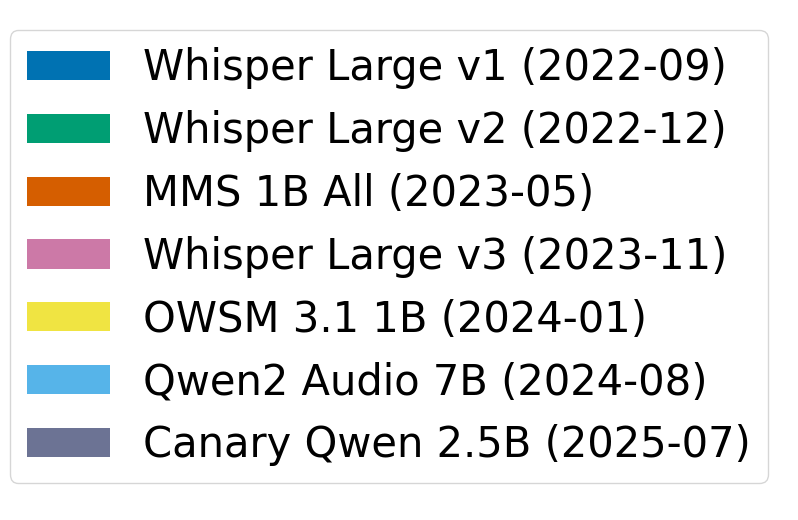

In [11]:
handles,labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(10, 6.5))
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend(handles, labels, loc="best", fontsize=30)
ax_legend.axis(False)
plt.show()


=== Dataset: L1-Arctic ===
  native_language  avg_regression  max_regression
0        Canadian       -0.004304        0.014189
1           Dutch       -0.008806        0.009428
2          German       -0.004497        0.014472
3          Indian       -0.011997        0.064516
4           Irish       -0.005238        0.022887
5        Scottish       -0.003679        0.041307
6             USA       -0.004094        0.012203

Max regression (Indian): 6.45%

Native regression (USA): 1.22%

Average max regression (all languages except USA): 2.78%

Average max regression (all languages): 2.56%


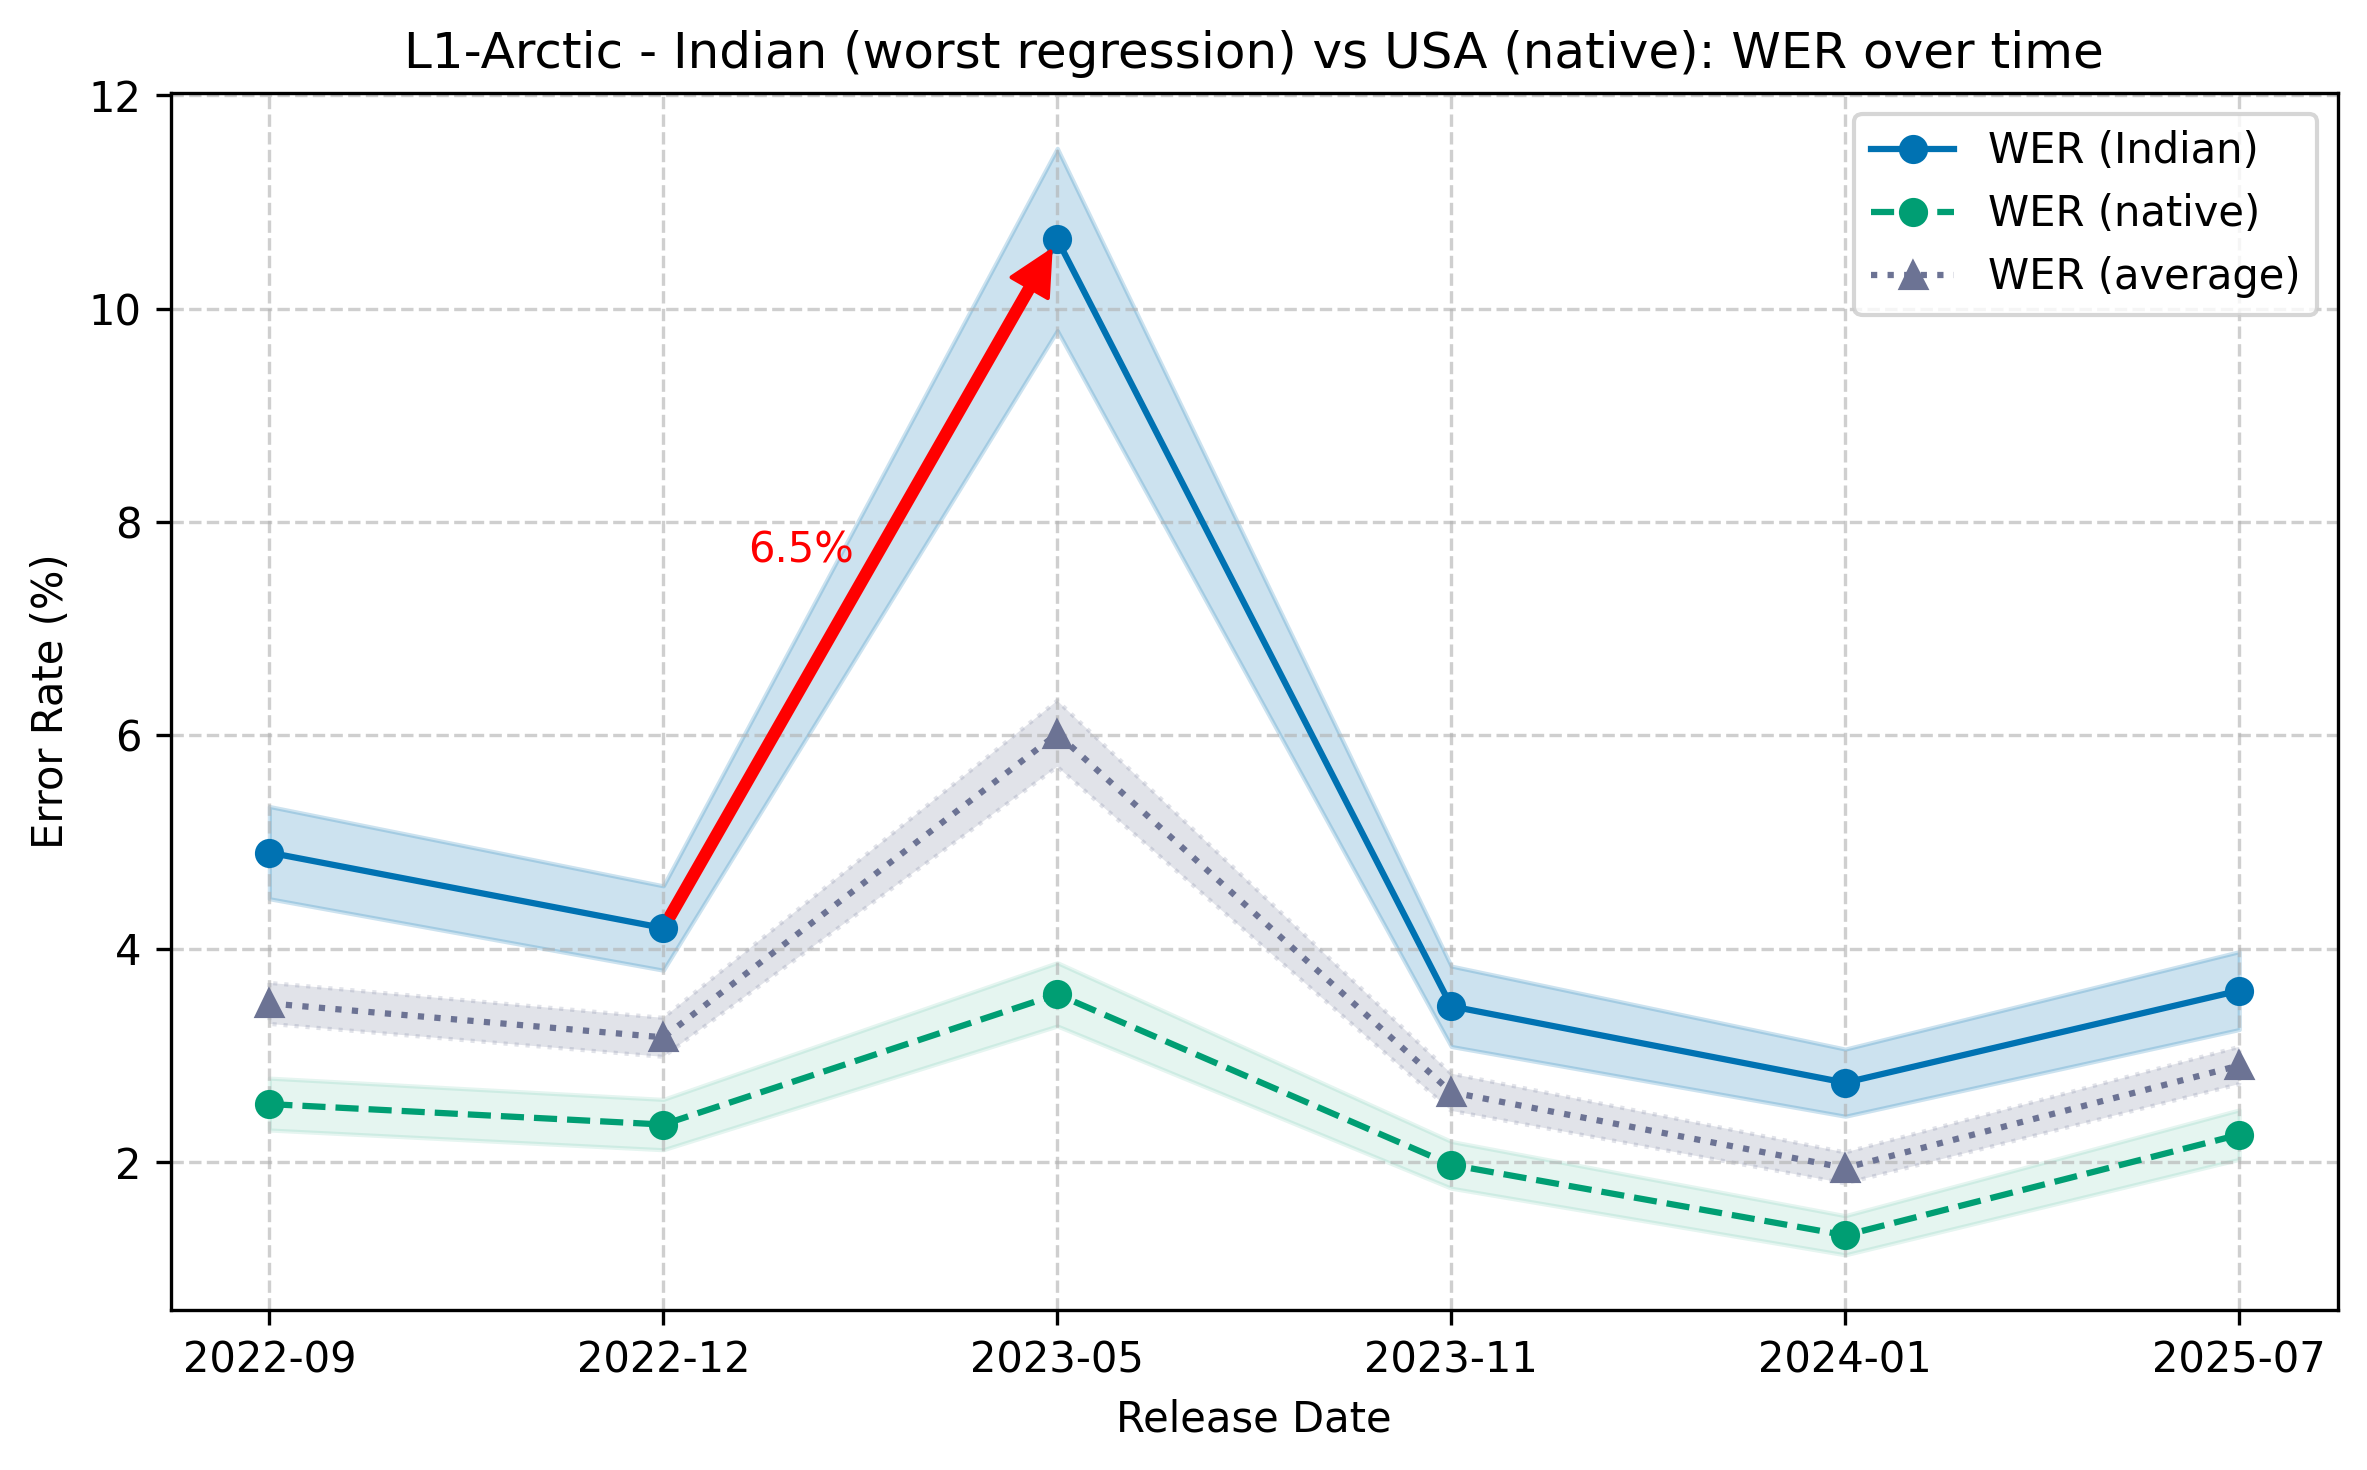


=== Dataset: L2-Arctic ===
  native_language  avg_regression  max_regression
0          Arabic       -0.234049        0.100654
1         Chinese       -0.091417        0.078221
2           Hindi       -0.121882        0.068452
3          Korean       -0.028380        0.265476
4         Spanish       -0.226418        0.065923
5             USA       -0.004094        0.012203
6      Vietnamese       -0.046644        0.186450

Max regression (Korean): 26.55%

Native regression (USA): 1.22%

Average max regression (all languages except USA): 12.75%

Average max regression (all languages): 11.11%


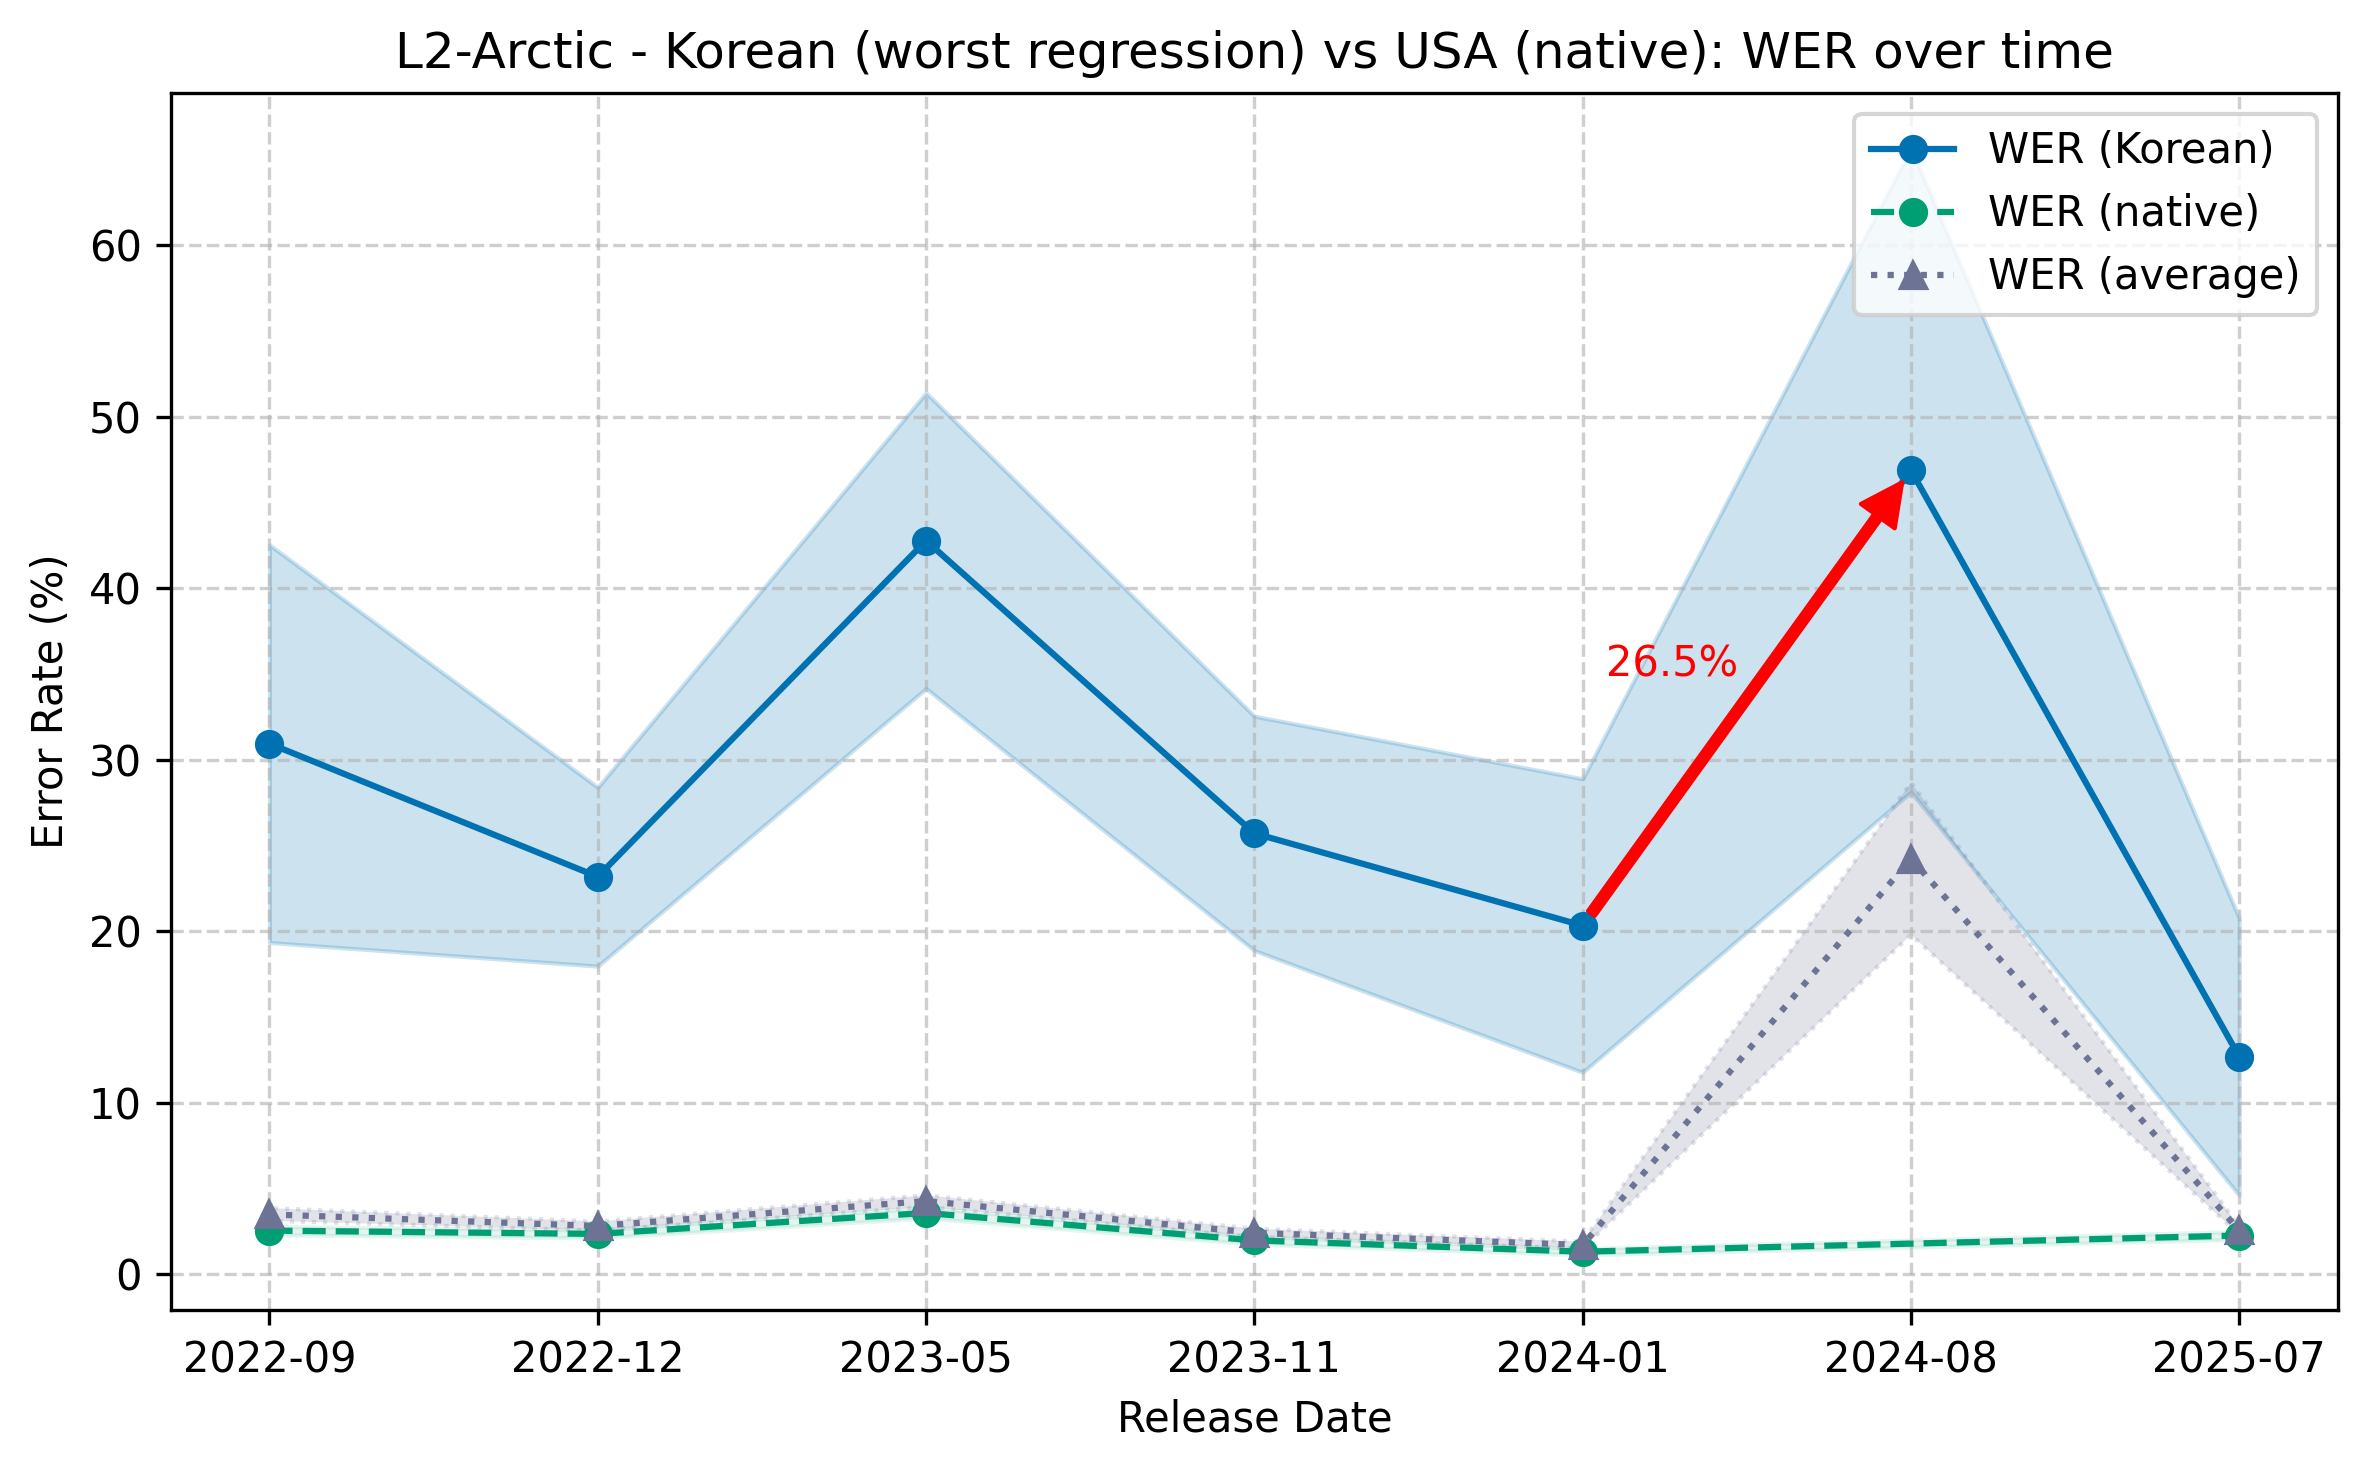


=== Dataset: Openslr83 ===
    native_language  avg_regression  max_regression
0     Irish English        0.010084        0.131532
1  Midlands English        0.000178        0.079257
2  Northern English       -0.000028        0.053379
3  Scottish English        0.003885        0.062237
4  Southern English        0.007570        0.064459
5     Welsh English       -0.003318        0.067311

Max regression (Irish English): 13.15%

Native regression (Southern English): 6.45%

Average max regression (all languages except Southern English): 7.87%

Average max regression (all languages): 7.64%


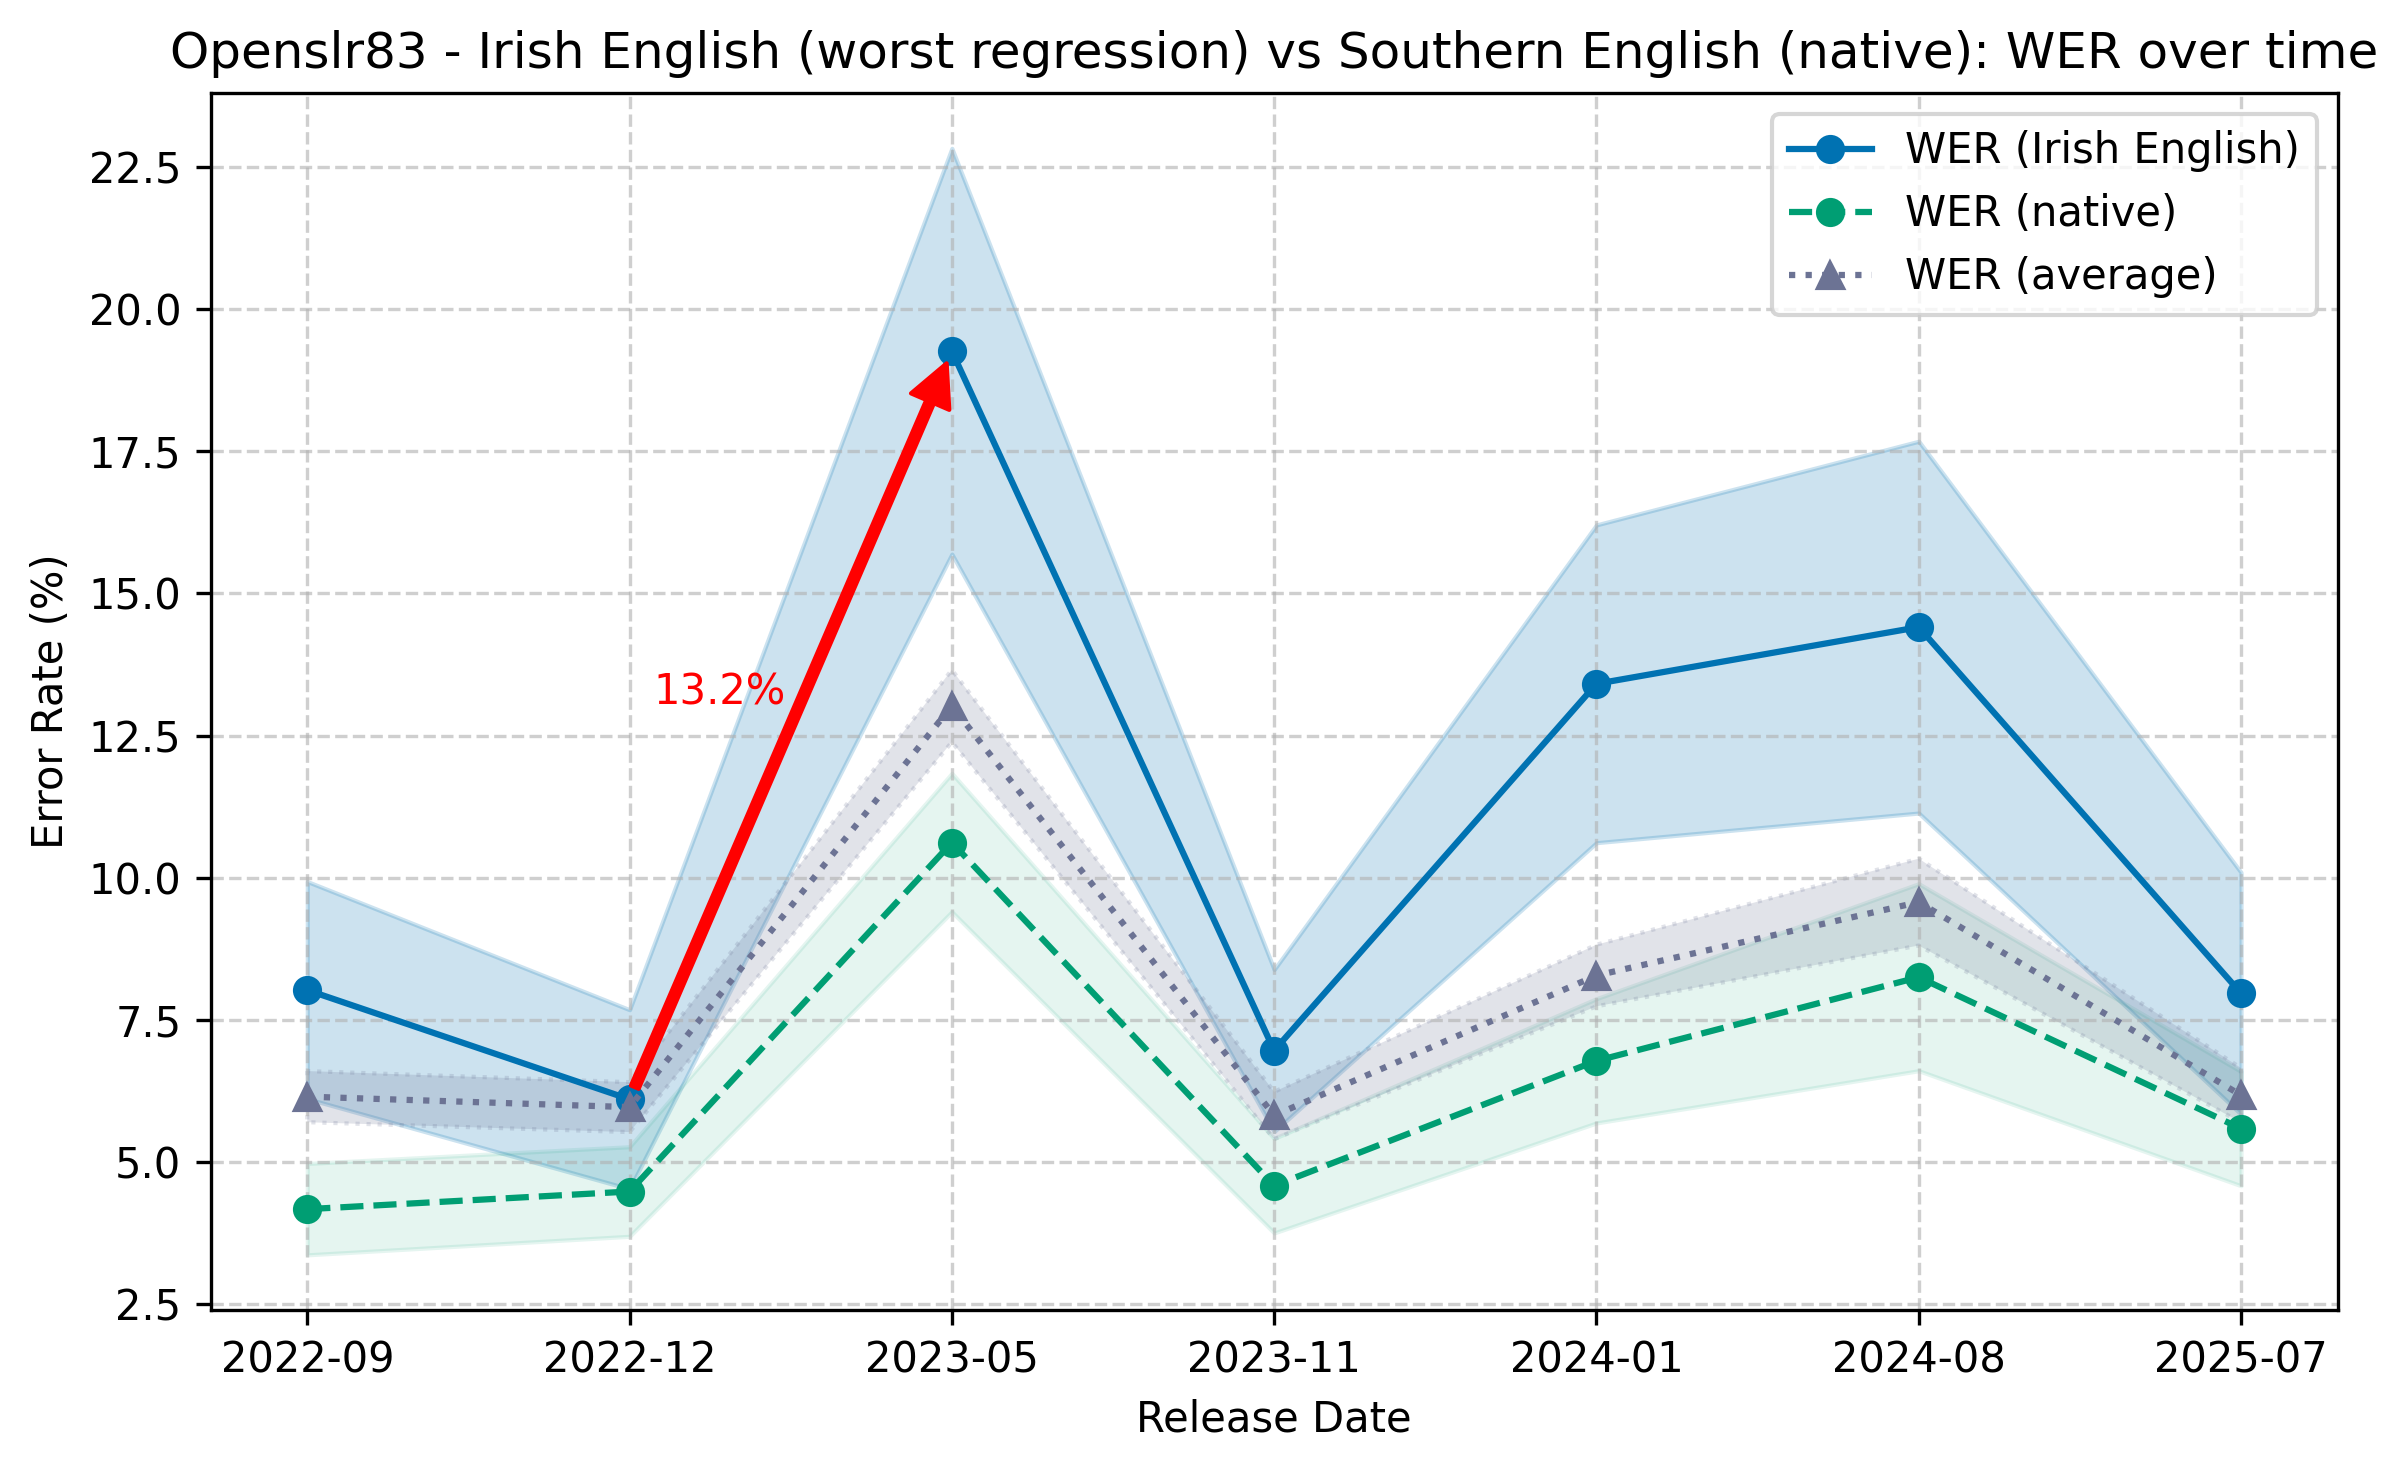


=== Dataset: SAA ===
  native_language  avg_regression  max_regression
0         Amharic       -0.105138        0.074190
1          Arabic       -0.083627        0.067940
2         Bengali       -0.073958        0.062201
3       Bulgarian       -0.056506        0.057355
4       Cantonese       -0.103091        0.147605
5           Dutch       -0.099184        0.008931
6         English       -0.104118        0.019979
7           Farsi       -0.089770        0.079844
8          French       -0.140253        0.066203
9          German       -0.105691        0.037594

Max regression (Cantonese): 14.76%

Native regression (English): 2.00%

Average max regression (all languages except English): 7.53%

Average max regression (all languages): 7.29%


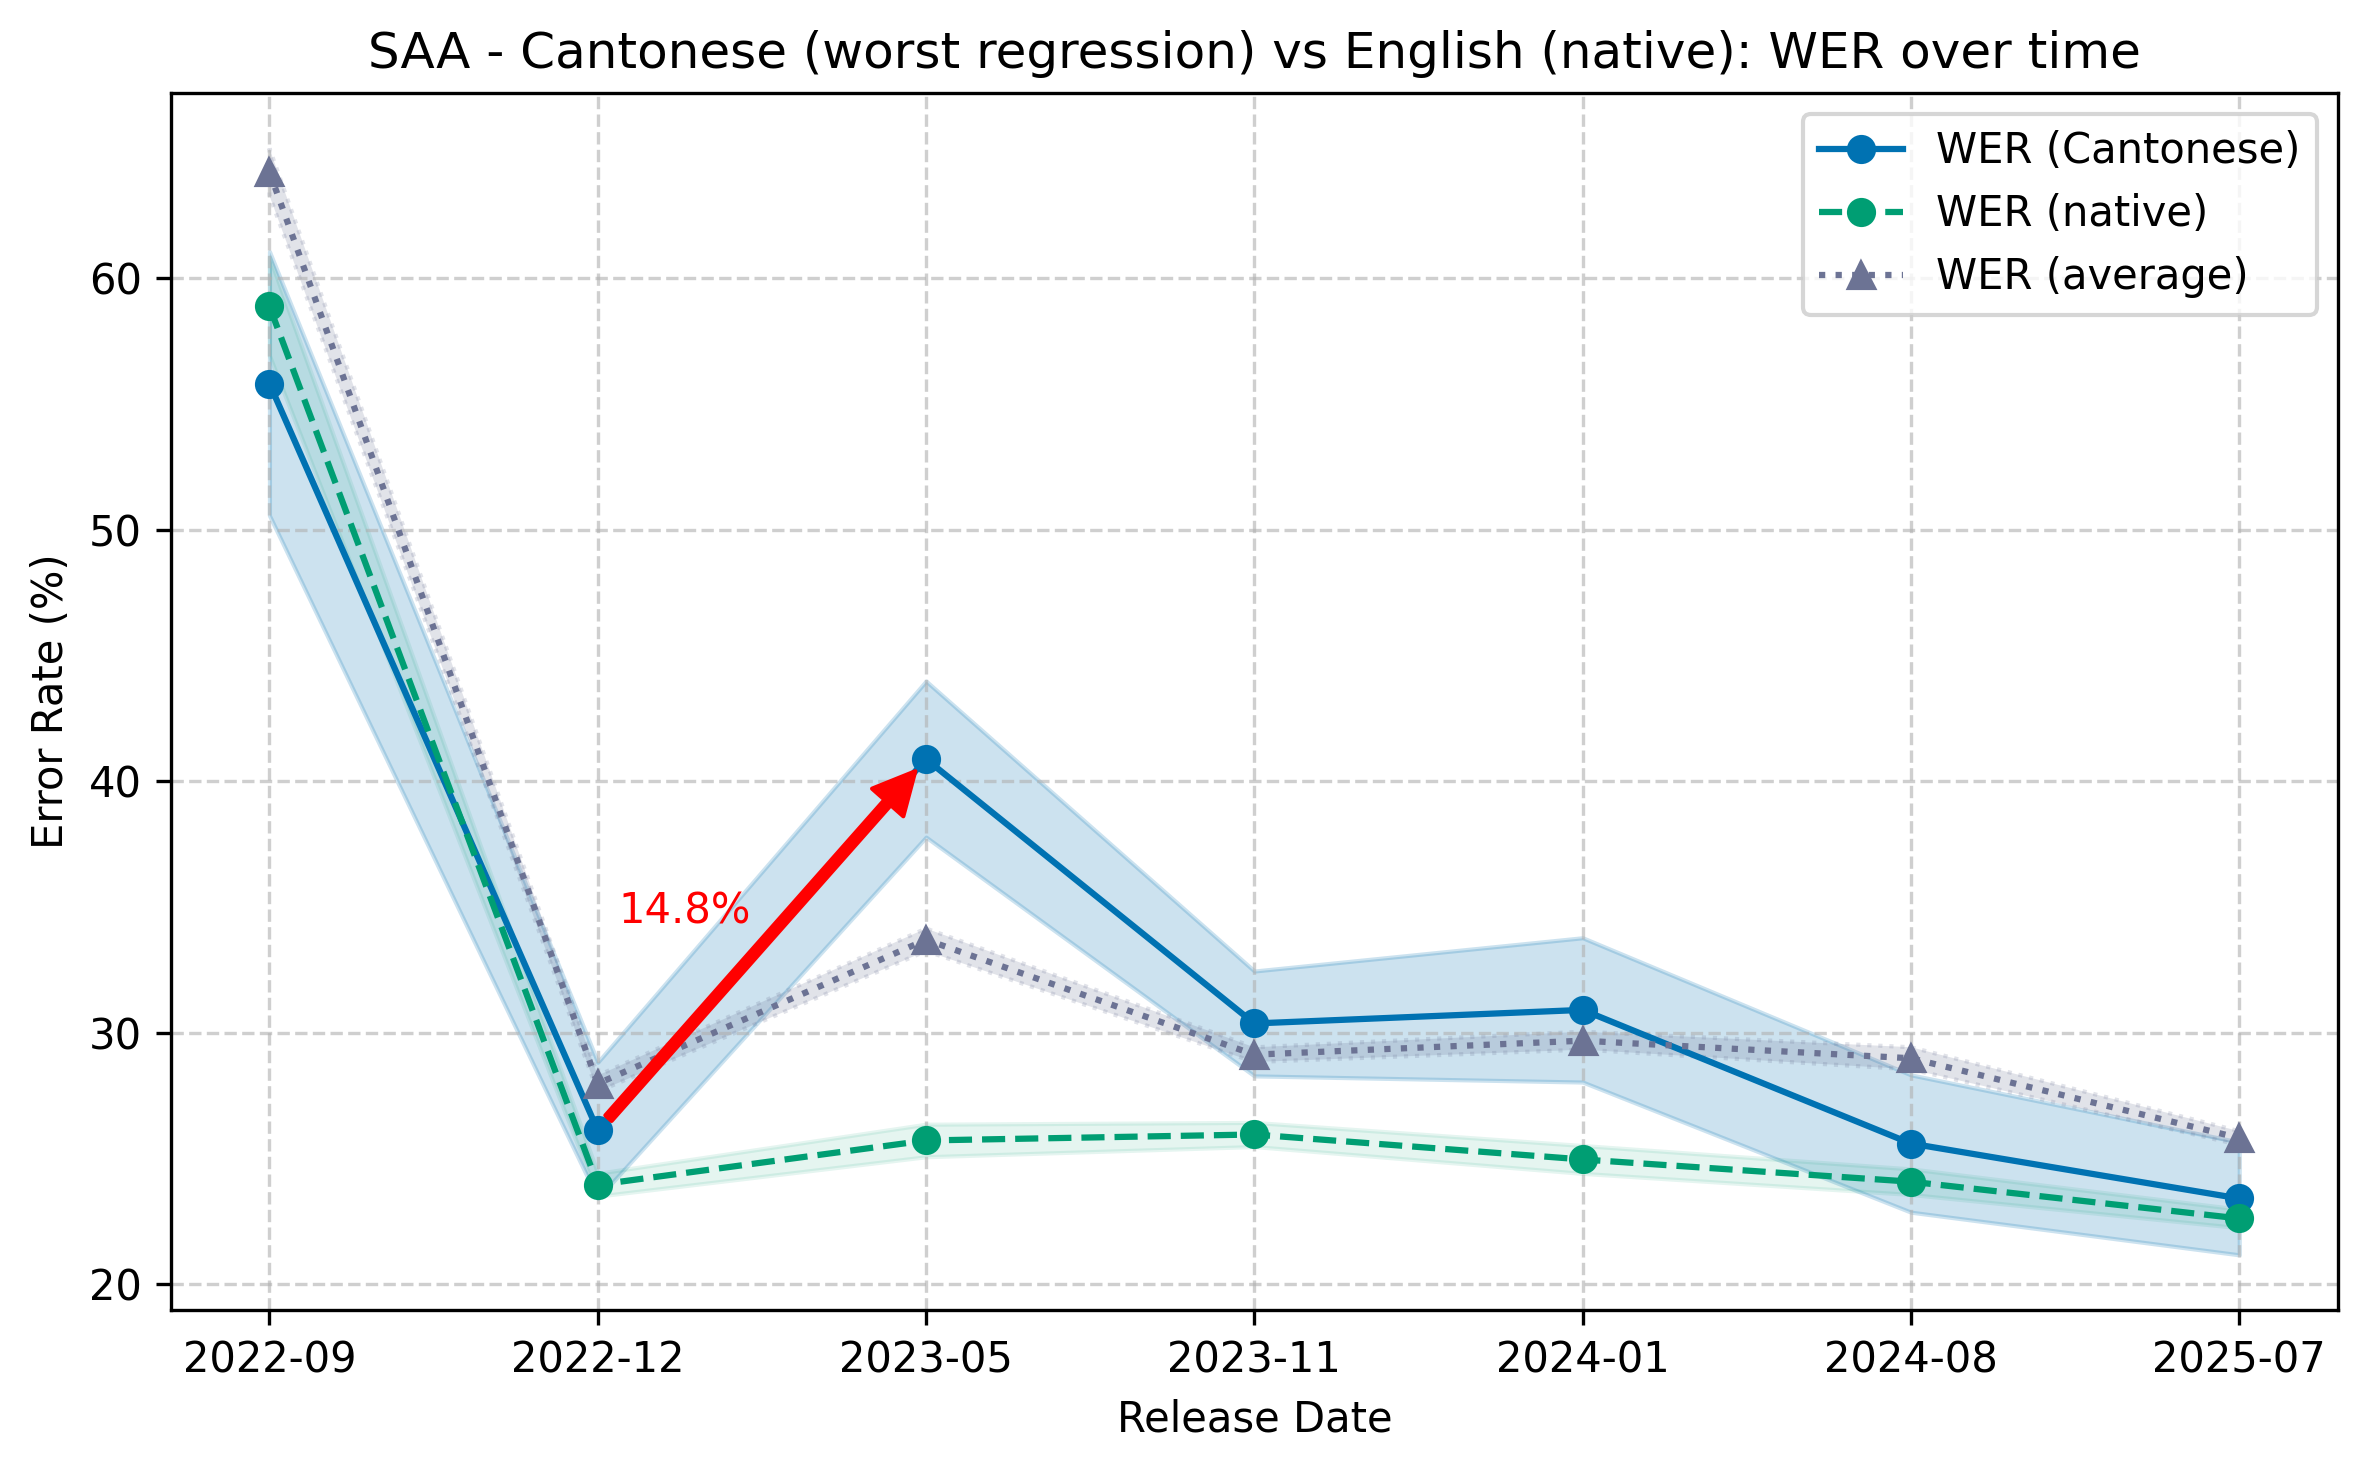

In [102]:
WER_COLOR = colors[0]
WER_NATIVE_COLOR = colors[1]
CER_COLOR = colors[2]
CER_NATIVE_COLOR = colors[3]
UNCONDITIONAL_COLOR = colors[-1]
INCLUDE_CER = False
REQUIRE_NATIVE = True
INCLUDE_UNCONDITIONAL = True
# STATISTIC = 'median'
STATISTIC = 'mean'
# ERROR_METRIC = 'std'
ERROR_METRIC = 'sem'
FALLBACK_L1_DATASET = {
    'L2-Arctic': 'L1-Arctic'
}
SHOW_MAX_REGRESSION_ARROW = True

plt.rcParams['figure.dpi'] = 300
for dataset, df_d in results.groupby('dataset'):      
    # outliers
    df_d = df_d[(df_d["cer"] <= 1) & (df_d["wer"] <= 1)] # drop outliers
    MIN_SAMPLES = 10 if 'SAA' in dataset else 2 # type: ignore ; ensure we have at least MIN_SAMPLES samples for a language to include it
    t = pd.DataFrame(df_d['native_language'].value_counts() / len(df_d['model'].unique()) > MIN_SAMPLES).reset_index()
    t = t[t['count']]['native_language'].unique()
    df_d = df_d[df_d['native_language'].isin(t)]

    # Determine native language
    native_lang = set(df_d['native_language']).intersection(['USA', 'Southern English', 'English'])
    native_lang = native_lang.pop() if len(native_lang) > 0 else None
    if native_lang is None and dataset in FALLBACK_L1_DATASET:
        native_lang = 'USA'
        df_d = pd.concat([df_d, results[(results['dataset'] == FALLBACK_L1_DATASET[dataset]) & (results['native_language'] == native_lang)]]) # type: ignore

    # Compute regression (max diff of newer_model_wer - older_model_wer)
    regressions = []
    res = []
    max_pairs = {}
    for lang, df_lang in df_d.groupby('native_language'):
        df_lang_sorted = (
            df_lang.groupby(['model', 'release_date'])
            .agg({'wer': STATISTIC, 'cer': STATISTIC})
            .reset_index()
            .sort_values('release_date')
        )
        
        # Compute pairwise WER differences over time
        max_regression = avg_regression = 0.0
        max_pair = (None, None)
        count = 0
        for i in range(len(df_lang_sorted)):
            for j in range(i + 1, len(df_lang_sorted)):
                diff = df_lang_sorted.iloc[j]['wer'] - df_lang_sorted.iloc[i]['wer']
                if diff > max_regression:
                    max_regression = diff
                    # max_pair = (df_lang_sorted.iloc[i]['release_date'], df_lang_sorted.iloc[i]['release_date'])
                    max_pair = (i, j)
                avg_regression += diff
                count += 1
        avg_regression /= count
        max_pairs[lang] = max_pair
        
        res.append({
            'native_language': lang,
            'avg_regression': avg_regression,
            'max_regression': max_regression
        })
        regressions.append(max_regression)
    
    # Convert to DataFrame and print
    reg_df = pd.DataFrame(res)

    top_lang = reg_df.loc[reg_df['max_regression'].idxmax(), 'native_language']
    if REQUIRE_NATIVE and not (native_lang and native_lang != top_lang):
        continue

    # Print overall stats
    print(f"\n=== Dataset: {dataset} ===")
    print(reg_df.head(10))
    print(f"\nMax regression ({top_lang}): {reg_df['max_regression'].max() * 100:.2f}%")
    if native_lang and native_lang != top_lang:
        print(f"\nNative regression ({native_lang}): {reg_df[reg_df['native_language'] == native_lang]['max_regression'].to_list()[0] * 100:.2f}%")
        print(f"\nAverage max regression (all languages except {native_lang}): {reg_df[reg_df['native_language'] != native_lang]['max_regression'].mean() * 100:.2f}%")
    print(f"\nAverage max regression (all languages): {reg_df['max_regression'].mean() * 100:.2f}%")
    
    # Plot WER and CER over time for that language
    df_plot = (
        df_d[df_d['native_language'] == top_lang]
        .groupby(['release_date', 'model'])
        .agg({'wer': [STATISTIC, ERROR_METRIC], 'cer': [STATISTIC, ERROR_METRIC]}) # type: ignore
        .reset_index()
    )
    df_plot.columns = ['release_date', 'model', 'wer_mean', 'wer_std', 'cer_mean', 'cer_std']
    df_plot = df_plot.sort_values('release_date')

    # Also plot the native dialect if present in the dataset
    if native_lang and native_lang != top_lang:
        df_native_plot = (
            df_d[df_d['native_language'] == native_lang]
            .groupby(['release_date', 'model'])
            .agg({'wer': [STATISTIC, ERROR_METRIC], 'cer': [STATISTIC, ERROR_METRIC]})
            .reset_index()
        )
        df_native_plot.columns = ['release_date', 'model', 'wer_mean', 'wer_std', 'cer_mean', 'cer_std']
        df_native_plot = df_native_plot.sort_values('release_date')
    else:
        df_native_plot = None
    
    plt.figure(figsize=(8, 5))
    wer_line, = plt.plot(df_plot['release_date'], df_plot['wer_mean'] * 100, '-o', color=WER_COLOR, label=f'WER ({top_lang})')
    plt.fill_between(
        df_plot['release_date'],
        (df_plot['wer_mean'] - df_plot['wer_std']) * 100, # type: ignore
        (df_plot['wer_mean'] + df_plot['wer_std']) * 100, # type: ignore
        color=wer_line.get_color(), alpha=0.2
    )
    if INCLUDE_CER:
        cer_line, = plt.plot(df_plot['release_date'], df_plot['cer_mean'] * 100, '-s', color=CER_COLOR, label=f'CER ({top_lang})')
        plt.fill_between(
            df_plot['release_date'],
            (df_plot['cer_mean'] - df_plot['cer_std']) * 100, # type: ignore
            (df_plot['cer_mean'] + df_plot['cer_std']) * 100, # type: ignore
            color=cer_line.get_color(), alpha=0.2
        )

    if df_native_plot is not None:
        wer_line, = plt.plot(df_native_plot['release_date'], df_native_plot['wer_mean'] * 100, '--o',
             color=WER_NATIVE_COLOR, label='WER (native)')
        plt.fill_between(
            df_native_plot['release_date'],
            (df_native_plot['wer_mean'] - df_native_plot['wer_std']) * 100, # type: ignore
            (df_native_plot['wer_mean'] + df_native_plot['wer_std']) * 100, # type: ignore
            color=wer_line.get_color(), alpha=0.1
        )
        if INCLUDE_CER:
            cer_line, = plt.plot(df_native_plot['release_date'], df_native_plot['cer_mean'] * 100, '--s',
                    color=CER_NATIVE_COLOR, label='CER (native)')
            plt.fill_between(
                df_native_plot['release_date'],
                (df_native_plot['cer_mean'] - df_native_plot['cer_std']) * 100, # type: ignore
                (df_native_plot['cer_mean'] + df_native_plot['cer_std']) * 100, # type: ignore
                color=cer_line.get_color(), alpha=0.1
            )

    if INCLUDE_UNCONDITIONAL:
        df_overall = df_d.groupby(['release_date', 'model']).agg({'wer': [STATISTIC, ERROR_METRIC], 'cer': [STATISTIC, ERROR_METRIC]}).reset_index() # type: ignore
        df_overall.columns = ['release_date', 'model', 'wer_mean', 'wer_std', 'cer_mean', 'cer_std']
        df_overall = df_overall.sort_values('release_date')
        wer_line, = plt.plot(df_overall['release_date'], df_overall['wer_mean'] * 100, ':^', color=UNCONDITIONAL_COLOR, label='WER (average)')
        plt.fill_between(
            df_overall['release_date'],
            (df_overall['wer_mean'] - df_overall['wer_std']) * 100, # type: ignore
            (df_overall['wer_mean'] + df_overall['wer_std']) * 100, # type: ignore
            color=wer_line.get_color(), alpha=0.2, linestyle=':'
        )

    if SHOW_MAX_REGRESSION_ARROW:
        release_date_locations, _ = plt.xticks()
        max_pair = max_pairs[top_lang]
        start_x = release_date_locations[max_pair[0]]
        start_y = 100 * df_plot.iloc[max_pair[0]]['wer_mean']
        end_x = release_date_locations[max_pair[1]]
        end_y = 100 * df_plot.iloc[max_pair[1]]['wer_mean']
        norm = (plt.ylim()[1] - plt.ylim()[0]) / 100
        head_length = 2 * norm
        dir = np.array([end_x - start_x, end_y - start_y])
        mag = np.linalg.norm(dir)
        dir /= mag
        mag -= head_length + 2 * norm
        # plt.arrow(start_x + 1 * norm * dir[0], start_y + 1 * norm * dir[1], dir[0] * mag, dir[1] * mag, color='red', zorder=3, width=0.02, head_width=0.1, head_length=head_length) 
        plt.annotate("", xy=(end_x - 1 * norm * dir[0], end_y - 1 * norm * dir[1]), xytext=(start_x + 1 * norm * dir[0], start_y + 1 * norm * dir[1]), arrowprops=dict(headlength=10, headwidth=10, width=2, color='red'))
        label = f"{end_y - start_y:.1f}%"
        plt.text((start_x + end_x) / 2 - norm * dir[0], (start_y + end_y) / 2 + norm * dir[1], label, color="red", verticalalignment='bottom', horizontalalignment='right')

    plt.title(f"{dataset} - {top_lang} (worst regression) vs {native_lang} (native): WER{' & CER ' if INCLUDE_CER else ' '}over time")
    plt.xlabel("Release Date")
    plt.ylabel("Error Rate (%)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()